In [13]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import BCDUnet
from ImageLoader import ImageLoader2D

In [14]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "BCDUnet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 150
min_loss_for_saving = 0.9

In [16]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 100


100it [00:09, 10.09it/s]


In [17]:
# from sklearn.model_selection import KFold

# seed_value = 42
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed_value)

# for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#     if fold == 4:
#         x_train, x_test = X[train_idx], X[test_idx]
#         y_train, y_test = Y[train_idx], Y[test_idx]

#         x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle=True, random_state=seed_value)

#         print(f"Selected Fold: {fold + 1}")
#         print("Training Set:", x_train.shape, y_train.shape)
#         print("Validation Set:", x_valid.shape, y_valid.shape)
#         print("Test Set:", x_test.shape, y_test.shape)

In [18]:
# Splitting the data, seed for reproducibility
seed_value = 42
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)
print(f"Using random seed {seed_value}")
print(f"Train Set Size {len(x_train)}")
print(f"Valid Set Size {len(x_valid)}")
print(f"Test Set Size {len(x_test)}")


Using random seed 42
Train Set Size 80
Valid Set Size 10
Test Set Size 10


In [19]:
# Defining the augmentations

aug__horizon_train = albu.Compose([
    albu.HorizontalFlip(),
])

aug__vertical_train = albu.Compose([
    albu.VerticalFlip(),
])

aug__color_train = albu.Compose([
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
])

aug__affine_train = albu.Compose([
    albu.Affine(),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        horizon = aug__horizon_train(image=x_train[i], mask=y_train[i])
        vertical = aug__vertical_train(image=x_train[i], mask=y_train[i])
        color = aug__color_train(image=x_train[i], mask=y_train[i])
        affine = aug__affine_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(horizon['image'])  
        y_train_out.append(horizon['mask'])
        x_train_out.append(vertical['image'])  
        y_train_out.append(vertical['mask'])
        x_train_out.append(color['image'])  
        y_train_out.append(color['mask'])
        x_train_out.append(affine['image'])  
        y_train_out.append(affine['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [20]:
# Creating the model

model = BCDUnet.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

In [21]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [22]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
80/80 [==============================] - 20s 176ms/step - loss: 0.6787 - val_loss: 0.8270
Loss Validation: 0.8235396
Loss Test: 0.9042347
Saved model with val_loss:  0.8235396


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 1
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.5562 - val_loss: 0.7267
Loss Validation: 0.72334486
Loss Test: 0.8468165
Saved model with val_loss:  0.72334486


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 2
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.4984 - val_loss: 0.7145
Loss Validation: 0.7112259
Loss Test: 0.83397245
Saved model with val_loss:  0.7112259


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 3
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.4382 - val_loss: 0.5420
Loss Validation: 0.52786463
Loss Test: 0.68485034
Saved model with val_loss:  0.52786463


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 4
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.4133 - val_loss: 0.5570
Loss Validation: 0.561774
Loss Test: 0.75691843
Training, epoch 5
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.3806 - val_loss: 0.4770
Loss Validation: 0.46430892
Loss Test: 0.65944755
Saved model with val_loss:  0.46430892


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 6
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.3459 - val_loss: 0.4388
Loss Validation: 0.4219309
Loss Test: 0.51818955
Saved model with val_loss:  0.4219309


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 7
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.3158 - val_loss: 0.4074
Loss Validation: 0.3880418
Loss Test: 0.43911523
Saved model with val_loss:  0.3880418


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 8
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.2951 - val_loss: 0.4177
Loss Validation: 0.39886373
Loss Test: 0.5107131
Training, epoch 9
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.2742 - val_loss: 0.3962
Loss Validation: 0.37603116
Loss Test: 0.46047688
Saved model with val_loss:  0.37603116


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 10
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.2576 - val_loss: 0.3865
Loss Validation: 0.37030637
Loss Test: 0.37900472
Saved model with val_loss:  0.37030637


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 11
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.2427 - val_loss: 0.3675
Loss Validation: 0.34146732
Loss Test: 0.3703537
Saved model with val_loss:  0.34146732


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 12
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.2202 - val_loss: 0.3549
Loss Validation: 0.33284438
Loss Test: 0.3562894
Saved model with val_loss:  0.33284438


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 13
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.2138 - val_loss: 0.3824
Loss Validation: 0.3628828
Loss Test: 0.51361436
Training, epoch 14
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.2058 - val_loss: 0.3899
Loss Validation: 0.36933368
Loss Test: 0.38730806
Training, epoch 15
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.1879 - val_loss: 0.3580
Loss Validation: 0.33808666
Loss Test: 0.34949428
Training, epoch 16
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.1759 - val_loss: 0.3447
Loss Validation: 0.32290858
Loss Test: 0.3400054
Saved model with val_loss:  0.32290858


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 17
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1616 - val_loss: 0.3357
Loss Validation: 0.30758858
Loss Test: 0.32185668
Saved model with val_loss:  0.30758858


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 18
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1607 - val_loss: 0.3257
Loss Validation: 0.301382
Loss Test: 0.31480342
Saved model with val_loss:  0.301382


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 19
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1442 - val_loss: 0.3560
Loss Validation: 0.3328997
Loss Test: 0.3435158
Training, epoch 20
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1436 - val_loss: 0.3326
Loss Validation: 0.31296784
Loss Test: 0.30764586
Training, epoch 21
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.1314 - val_loss: 0.3299
Loss Validation: 0.30822867
Loss Test: 0.29370904
Training, epoch 22
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.1272 - val_loss: 0.3204
Loss Validation: 0.2985741
Loss Test: 0.29504585
Saved model with val_loss:  0.2985741


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 23
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1147 - val_loss: 0.3297
Loss Validation: 0.30433178
Loss Test: 0.3086729
Training, epoch 24
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1120 - val_loss: 0.2983
Loss Validation: 0.2781729
Loss Test: 0.25898224
Saved model with val_loss:  0.2781729


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 25
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.1055 - val_loss: 0.2951
Loss Validation: 0.2740996
Loss Test: 0.25950807
Saved model with val_loss:  0.2740996


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 26
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.0979 - val_loss: 0.2933
Loss Validation: 0.27264434
Loss Test: 0.2707119
Saved model with val_loss:  0.27264434


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 27
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0929 - val_loss: 0.3193
Loss Validation: 0.29600042
Loss Test: 0.29201883
Training, epoch 28
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.0902 - val_loss: 0.3014
Loss Validation: 0.27731866
Loss Test: 0.22071654
Training, epoch 29
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0846 - val_loss: 0.3086
Loss Validation: 0.29283583
Loss Test: 0.2618882
Training, epoch 30
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0816 - val_loss: 0.3103
Loss Validation: 0.28446776
Loss Test: 0.27315146
Training, epoch 31
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0783 - val_loss: 0.3008
Loss Validation: 0.27920502
Loss Test: 0.27260172
Training, epoch 32
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 35
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0630 - val_loss: 0.3139
Loss Validation: 0.2968855
Loss Test: 0.2515688
Training, epoch 36
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0680 - val_loss: 0.3106
Loss Validation: 0.29684418
Loss Test: 0.21189755
Training, epoch 37
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0606 - val_loss: 0.3139
Loss Validation: 0.29008293
Loss Test: 0.21468574
Training, epoch 38
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0597 - val_loss: 0.3044
Loss Validation: 0.278809
Loss Test: 0.27211338
Training, epoch 39
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0591 - val_loss: 0.2670
Loss Validation: 0.25036168
Loss Test: 0.1938793
Saved model with val_loss:  0.25036168


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 40
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.0575 - val_loss: 0.3386
Loss Validation: 0.31866646
Loss Test: 0.21248686
Training, epoch 41
Learning Rate: 0.0001
80/80 [==============================] - 13s 167ms/step - loss: 0.0558 - val_loss: 0.2719
Loss Validation: 0.255741
Loss Test: 0.20011544
Training, epoch 42
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0528 - val_loss: 0.2835
Loss Validation: 0.26846868
Loss Test: 0.23172271
Training, epoch 43
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0537 - val_loss: 0.2777
Loss Validation: 0.25832194
Loss Test: 0.21853513
Training, epoch 44
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0508 - val_loss: 0.2874
Loss Validation: 0.2674901
Loss Test: 0.18058926
Training, epoch 45
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step -

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 46
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0557 - val_loss: 0.2519
Loss Validation: 0.24334472
Loss Test: 0.19529063
Training, epoch 47
Learning Rate: 0.0001
80/80 [==============================] - 13s 168ms/step - loss: 0.0556 - val_loss: 0.3038
Loss Validation: 0.27815807
Loss Test: 0.23509884
Training, epoch 48
Learning Rate: 0.0001
80/80 [==============================] - 12s 148ms/step - loss: 0.0489 - val_loss: 0.2912
Loss Validation: 0.2692185
Loss Test: 0.19666404
Training, epoch 49
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0488 - val_loss: 0.2770
Loss Validation: 0.26054215
Loss Test: 0.19526577
Training, epoch 50
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0428 - val_loss: 0.2574
Loss Validation: 0.23324877
Loss Test: 0.20696956
Saved model with val_loss:  0.23324877


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 51
Learning Rate: 0.0001
80/80 [==============================] - 11s 142ms/step - loss: 0.0458 - val_loss: 0.2888
Loss Validation: 0.26559728
Loss Test: 0.17292553
Training, epoch 52
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0471 - val_loss: 0.2648
Loss Validation: 0.25192356
Loss Test: 0.19048834
Training, epoch 53
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0457 - val_loss: 0.2627
Loss Validation: 0.2456243
Loss Test: 0.2187149
Training, epoch 54
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0439 - val_loss: 0.2892
Loss Validation: 0.26740104
Loss Test: 0.20443821
Training, epoch 55
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0434 - val_loss: 0.3021
Loss Validation: 0.27809566
Loss Test: 0.26631552
Training, epoch 56
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 74
Learning Rate: 0.0001
80/80 [==============================] - 11s 142ms/step - loss: 0.0333 - val_loss: 0.2430
Loss Validation: 0.22538102
Loss Test: 0.19780338
Saved model with val_loss:  0.22538102


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2024_3_30_23_24_58\assets


Training, epoch 75
Learning Rate: 0.0001
80/80 [==============================] - 11s 142ms/step - loss: 0.0317 - val_loss: 0.2773
Loss Validation: 0.2577318
Loss Test: 0.18430048
Training, epoch 76
Learning Rate: 0.0001
80/80 [==============================] - 11s 142ms/step - loss: 0.0344 - val_loss: 0.3033
Loss Validation: 0.28159624
Loss Test: 0.19237322
Training, epoch 77
Learning Rate: 0.0001
80/80 [==============================] - 11s 142ms/step - loss: 0.0323 - val_loss: 0.3026
Loss Validation: 0.28619534
Loss Test: 0.24846166
Training, epoch 78
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0353 - val_loss: 0.2577
Loss Validation: 0.23872787
Loss Test: 0.19652587
Training, epoch 79
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step - loss: 0.0303 - val_loss: 0.3070
Loss Validation: 0.28553474
Loss Test: 0.2323057
Training, epoch 80
Learning Rate: 0.0001
80/80 [==============================] - 11s 143ms/step 

In [23]:
def postproccessing(image):
    kernels = [5, 10, 15]
    for k in kernels: 
        kernel = np.ones((k,k), np.uint8)
        # opening
        erosion1 = cv2.erode(image, kernel, iterations = 1)
        dilation1 = cv2.dilate(erosion1, kernel, iterations = 1)

        # closing
        dilation2 = cv2.dilate(dilation1, kernel, iterations = 1)
        erosion2 = cv2.erode(dilation2, kernel, iterations = 1)
        
        image = erosion2
    

    return image

Loading the model
3/3 [==============================] - 0s 46ms/step
results_BCDUnet_17_kvasir.txt


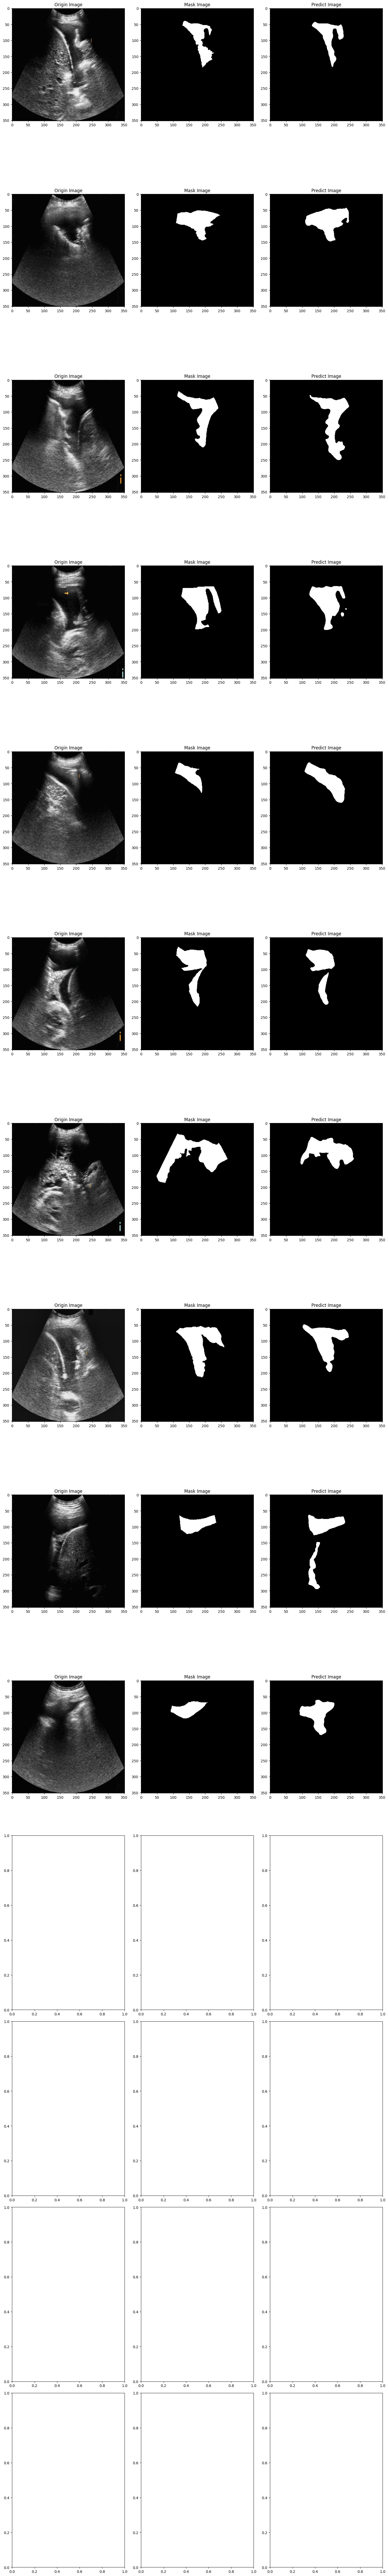

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
File done


In [24]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

# for i in range(len(prediction_test)):
#     prediction_test[i] = postproccessing(prediction_test[i])

fig, axs = plt.subplots(14, 3, figsize=(15, 100))

final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')
    
     # 計算個別數值
    dice_value = f1_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                         np.ndarray.flatten(prediction_test[i] > 0.5))
    miou_value = jaccard_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                              np.ndarray.flatten(prediction_test[i] > 0.5))
    precision_value = precision_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                      np.ndarray.flatten(prediction_test[i] > 0.5))
    recall_value = recall_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                np.ndarray.flatten(prediction_test[i] > 0.5))
    accuracy_value = accuracy_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                    np.ndarray.flatten(prediction_test[i] > 0.5))

    with open(final_file, 'a') as f:
        f.write(f'Metrics for sample {i + 1}:\n')
        f.write(f'Dice: {dice_value}\n')
        f.write(f'MIOU: {miou_value}\n')
        f.write(f'Precision: {precision_value}\n')
        f.write(f'Recall: {recall_value}\n')
        f.write(f'Accuracy: {accuracy_value}\n')
        f.write('\n')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')